c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


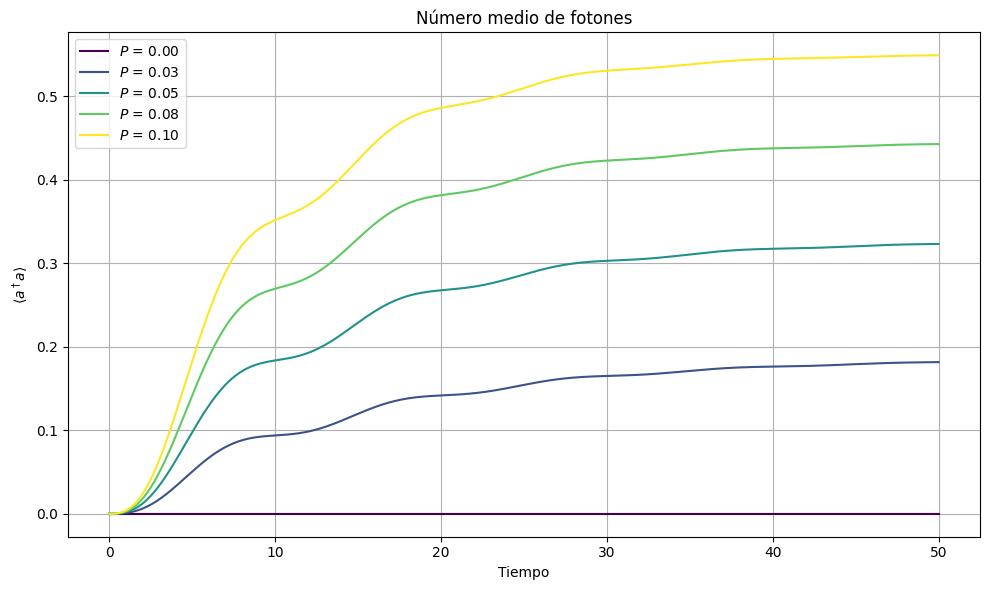

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

N = 5
d_qd = 2

# Parámetros físicos
wc = 1.0 * 2 * np.pi
wx = 1.0 * 2 * np.pi
g = 0.05 * 2 * np.pi

kappa = 0.1
gamma = 0.01
P_theta = 0.02
kappa2 = 0.01

# Tiempo
tlist = np.linspace(0, 50, 500)

# Operadores
a = tensor(destroy(N), qeye(d_qd))
adag = a.dag()
a2 = a * a
adag2 = adag * adag

sm = tensor(qeye(N), destroy(d_qd))
sp = sm.dag()
sz = sp * sm

phonon_jump = sm * adag

# Hamiltoniano JC
H = wc * adag * a + wx * sp * sm + g * (adag * sm + a * sp)

# Estado inicial: vacío
rho0 = ket2dm(tensor(basis(N, 0), basis(d_qd, 0)))

# Barrido en bombeo incoherente P
P_vals = np.linspace(0.0, 0.1, 5)

# Observable
n_op = adag * a

# Gráfica
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(P_vals)))

for i, P_val in enumerate(P_vals):
    # Redefinir canales de disipación
    c1 = np.sqrt(kappa) * a
    c2 = np.sqrt(gamma) * sm
    c3 = np.sqrt(P_theta) * phonon_jump
    c4 = np.sqrt(kappa2) * a2
    c5 = np.sqrt(P_val) * sp  # bombeo incoherente excitón
    c_ops = [c1, c2, c3, c4, c5]

    # Resolver
    result = mesolve(H, rho0, tlist, c_ops, [n_op])
    
    # Graficar
    plt.plot(tlist, result.expect[0], color=colors[i], label=f"$P$ = {P_val:.2f}")

plt.xlabel("Tiempo")
plt.ylabel(r"$\langle a^\dagger a \rangle$")
plt.title("Número medio de fotones")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
# Fijar valor de P para simulaciones siguientes
P = 0.05

# Reutilizar mismos operadores
a = tensor(destroy(N), qeye(d_qd))
adag = a.dag()
a2 = a * a
adag2 = adag * adag

sm = tensor(qeye(N), destroy(d_qd))
sp = sm.dag()
sz = sp * sm

phonon_jump = sm * adag

# Hamiltoniano Jaynes–Cummings
H = wc * adag * a + wx * sp * sm + g * (adag * sm + a * sp)

# Estado inicial: vacío
rho0 = ket2dm(tensor(basis(N, 0), basis(d_qd, 0)))

# Canales de disipación completos (incluyendo bombeo)
c1 = np.sqrt(kappa) * a
c2 = np.sqrt(gamma) * sm
c3 = np.sqrt(P_theta) * phonon_jump
c4 = np.sqrt(kappa2) * a2
c5 = np.sqrt(P) * sp
c_ops = [c1, c2, c3, c4, c5]


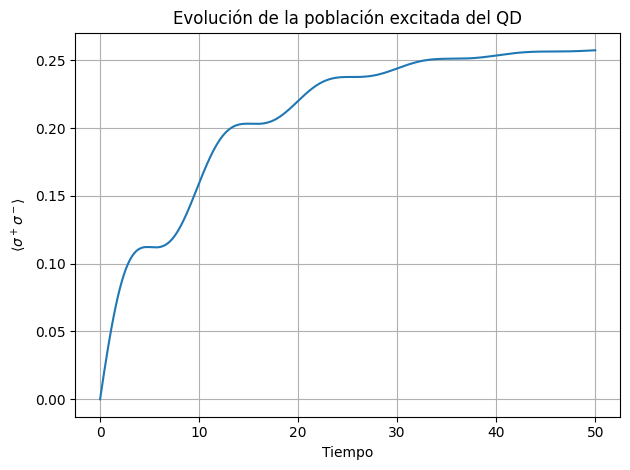

In [42]:
# Operadores del sistema total
a = tensor(destroy(N), qeye(2))         # Cavidad
adag = a.dag()
sm = tensor(qeye(N), destroy(2))        # Excitón
sp = sm.dag()
sz = sp * sm                            # Proyector sobre el estado excitado |1⟩⟨1|

# Resolver la dinámica para la inversión de población
result_inv = mesolve(H, rho0, tlist, c_ops, [sz])

# Graficar
plt.plot(tlist, result_inv.expect[0])
plt.xlabel("Tiempo")
plt.ylabel(r"$\langle \sigma^+ \sigma^- \rangle$")
plt.title("Evolución de la población excitada del QD")
plt.grid(True)
plt.tight_layout()
plt.show()



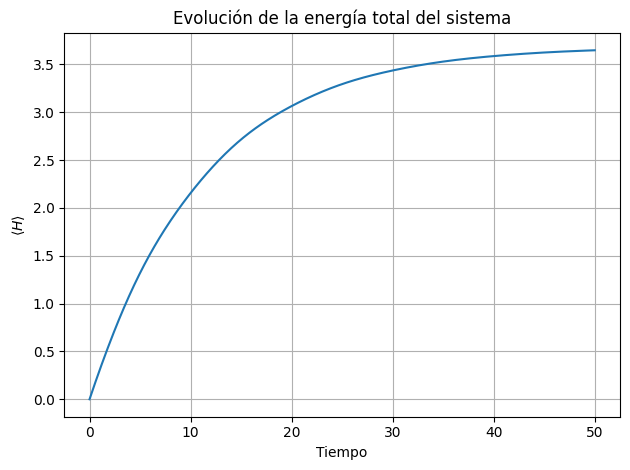

In [43]:
# Resolver la evolución temporal de la energía media ⟨H⟩
result_energy = mesolve(H, rho0, tlist, c_ops, [H])

# Graficar
plt.plot(tlist, result_energy.expect[0])
plt.xlabel("Tiempo")
plt.ylabel(r"$\langle H \rangle$")
plt.title("Evolución de la energía total del sistema")
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
# Operador de aniquilación de la cavidad en el espacio total
a = tensor(destroy(N), qeye(2))
a2 = a * a

# Observables
n_op = a.dag() * a
n2_op = a.dag() * a.dag() * a * a

# Estado estacionario bajo dinámica disipada
rho_ss = steadystate(H, c_ops)

# Expectation values
n_avg = expect(n_op, rho_ss)
n2_avg = expect(n2_op, rho_ss)

# Función de correlación de segundo orden en t=0
g2 = n2_avg / (n_avg ** 2) if n_avg > 0 else 0

# Imprimir resultado
print(f"g²(0) = {g2:.3f}")



g²(0) = 0.797


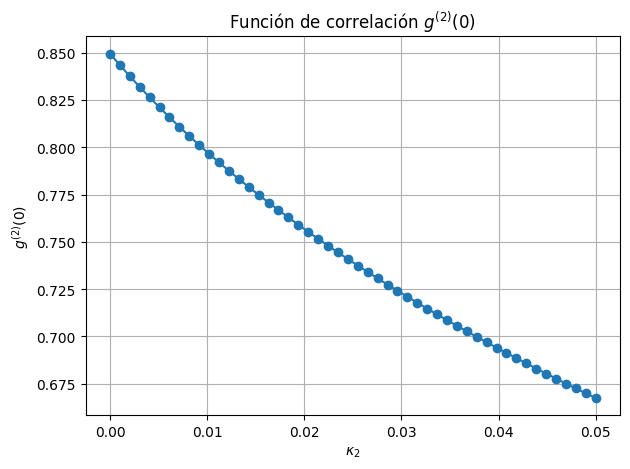

In [47]:
# Rango de valores de kappa_2
kappa2_vals = np.linspace(0, 0.05, 50)
g2_vals = []

# Observables
n_op = a.dag() * a
n2_op = a.dag() * a.dag() * a * a

for k2 in kappa2_vals:
    # Redefinir canales disipasivos para este kappa2
    c1 = np.sqrt(kappa) * a
    c2 = np.sqrt(gamma) * sm
    c3 = np.sqrt(P_theta) * phonon_jump
    c4 = np.sqrt(k2) * a2
    c5 = np.sqrt(P) * sp  
    c_ops_k = [c1, c2, c3, c4, c5]

    # Estado estacionario
    rho_ss = steadystate(H, c_ops_k)

    # Calcular observables
    n_avg = expect(n_op, rho_ss)
    n2_avg = expect(n2_op, rho_ss)

    # Calcular g²(0) con manejo de división por 0
    g2 = n2_avg / n_avg**2 if n_avg > 1e-10 else 0
    g2_vals.append(g2)

# Graficar
plt.plot(kappa2_vals, g2_vals, marker='o')
plt.xlabel(r'$\kappa_2$')
plt.ylabel(r'$g^{(2)}(0)$')
plt.title(r'Función de correlación $g^{(2)}(0)$')
plt.grid(True)
plt.tight_layout()
plt.show()


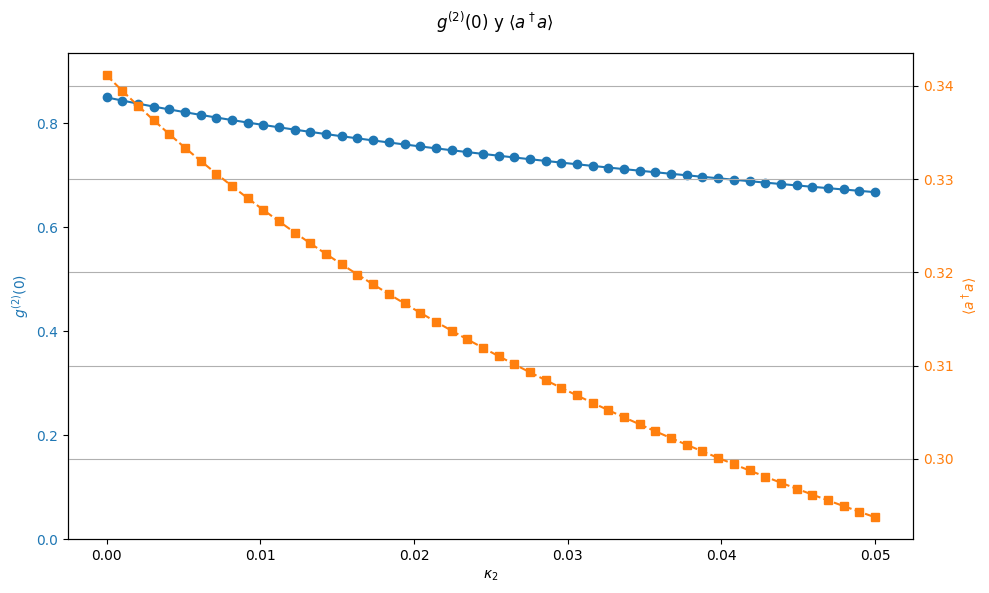

In [50]:
# Rango de valores de kappa_2
kappa2_vals = np.linspace(0, 0.05, 50)
g2_vals = []
n_vals = []

# Observables
n_op = a.dag() * a
n2_op = a.dag() * a.dag() * a * a

for k2 in kappa2_vals:
    # Redefinir canales disipasivos con bombeo
    c1 = np.sqrt(kappa) * a
    c2 = np.sqrt(gamma) * sm
    c3 = np.sqrt(P_theta) * phonon_jump
    c4 = np.sqrt(k2) * a2
    c5 = np.sqrt(P) * sp
    c_ops_k = [c1, c2, c3, c4, c5]

    # Estado estacionario
    rho_ss = steadystate(H, c_ops_k)

    # Observables
    n_avg = expect(n_op, rho_ss)
    n2_avg = expect(n2_op, rho_ss)

    g2 = n2_avg / n_avg**2 if n_avg > 1e-10 else 0
    g2_vals.append(g2)
    n_vals.append(n_avg)

# Graficar doble eje
fig, ax1 = plt.subplots(figsize=(10, 6))

# g²(0)
ax1.plot(kappa2_vals, g2_vals, 'o-', color='tab:blue', label=r'$g^{(2)}(0)$')
ax1.set_xlabel(r'$\kappa_2$')
ax1.set_ylabel(r'$g^{(2)}(0)$', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(g2_vals)*1.1)

# ⟨n⟩
ax2 = ax1.twinx()
ax2.plot(kappa2_vals, n_vals, 's--', color='tab:orange', label=r'$\langle a^\dagger a \rangle$')
ax2.set_ylabel(r'$\langle a^\dagger a \rangle$', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Título y leyenda
fig.suptitle(r'$g^{(2)}(0)$ y $\langle a^\dagger a \rangle$')
fig.tight_layout()
plt.grid(True)
plt.show()


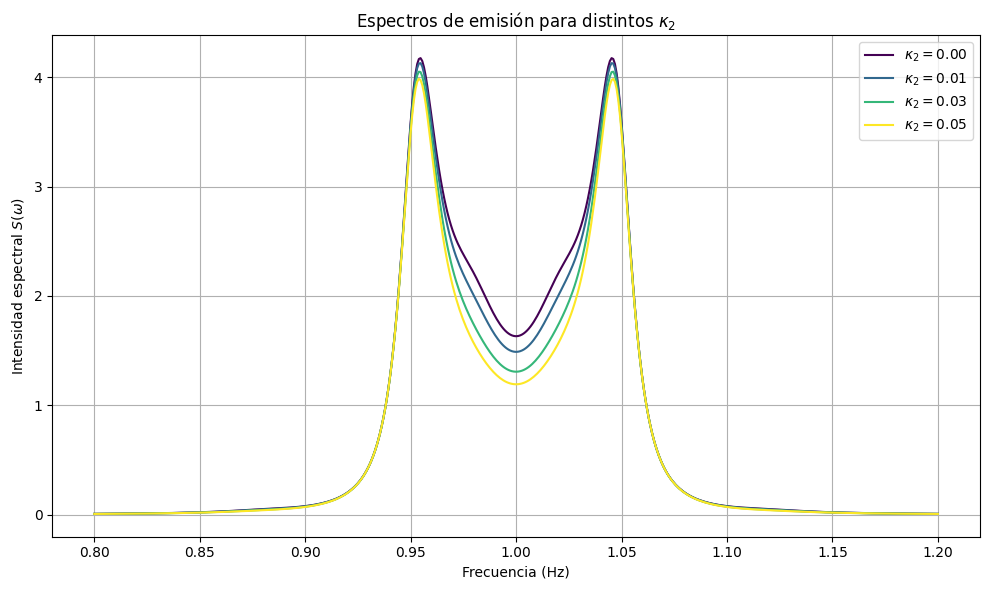

In [55]:
from qutip import spectrum


# Valores de kappa_2 para el barrido
kappa2_vals = [0.0, 0.01, 0.03, 0.05]

# Rango de frecuencias (en rad/s)
wlist = np.linspace(wc - 4*g, wc + 4*g, 500)

# Colores para las curvas
colors = plt.cm.viridis(np.linspace(0, 1, len(kappa2_vals)))

plt.figure(figsize=(10, 6))

for i, k2 in enumerate(kappa2_vals):
    # Redefinir canales disipasivos para cada kappa_2
    c1 = np.sqrt(kappa) * a
    c2 = np.sqrt(gamma) * sm
    c3 = np.sqrt(P_theta) * phonon_jump
    c4 = np.sqrt(k2) * a2
    c5 = np.sqrt(P) * sp
    c_ops_k = [c1, c2, c3, c4, c5]

    # Calcular el espectro con estos canales
    S_w = spectrum(H, wlist, c_ops_k, a.dag(), a)

    # Graficar
    plt.plot(wlist / (2 * np.pi), S_w, label=fr'$\kappa_2 = {k2:.2f}$', color=colors[i])

# Gráfica final
plt.xlabel("Frecuencia (Hz)")
plt.ylabel(r"Intensidad espectral $S(\omega)$")
plt.title(r"Espectros de emisión para distintos $\kappa_2$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


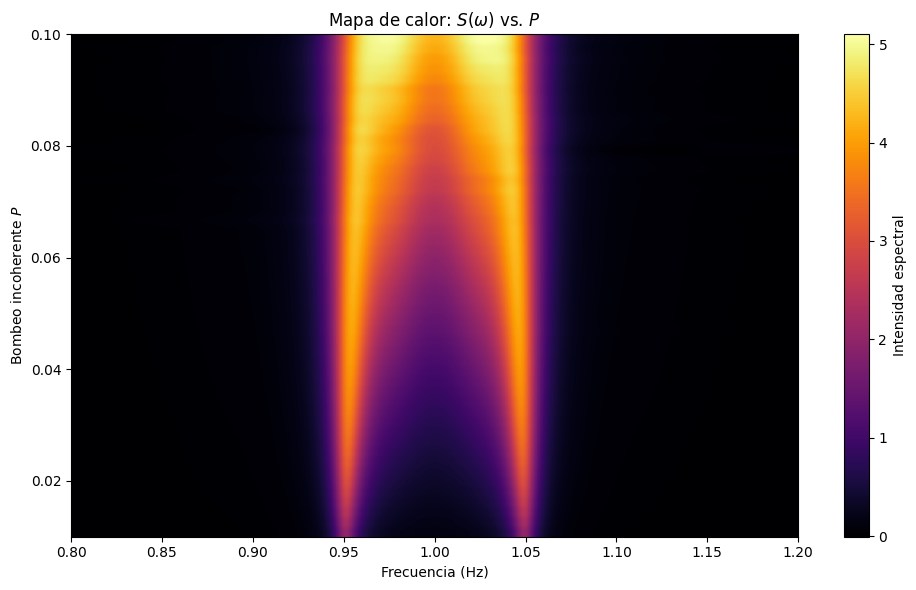

In [61]:
from qutip import spectrum
import numpy as np
import matplotlib.pyplot as plt

# Rango de valores de P
P_vals = np.linspace(0.01, 0.1, 50)

# Rango de frecuencias (rad/s)
wlist = np.linspace(wc - 4*g, wc + 4*g, 500)

# Matriz para guardar espectros
S_matrix = np.zeros((len(P_vals), len(wlist)))

# Calcular espectros para cada valor de P
for i, P_val in enumerate(P_vals):
    # Canales de disipación
    c1 = np.sqrt(kappa) * a
    c2 = np.sqrt(gamma) * sm
    c3 = np.sqrt(P_theta) * phonon_jump
    c4 = np.sqrt(kappa2) * a2
    c5 = np.sqrt(P_val) * sp
    c_ops_P = [c1, c2, c3, c4, c5]

    try:
        S_w = spectrum(H, wlist, c_ops_P, a.dag(), a)
        S_matrix[i, :] = S_w
    except Exception as e:
        print(f"Error en P = {P_val:.3f}: {e}")
        S_matrix[i, :] = np.zeros_like(wlist)

# Crear el mapa de calor
plt.figure(figsize=(10, 6))
extent = [wlist[0]/(2*np.pi), wlist[-1]/(2*np.pi), P_vals[0], P_vals[-1]]
plt.imshow(S_matrix, aspect='auto', extent=extent, origin='lower', cmap='inferno')
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Bombeo incoherente $P$")
plt.title(r"Mapa de calor: $S(\omega)$ vs. $P$")
plt.colorbar(label="Intensidad espectral")
plt.tight_layout()
plt.show()
